In [1]:
%matplotlib inline

In [2]:
# Load some libraries from Pytorch
import torch
from torch import nn
import torchvision
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms

In [3]:
# Check device, use GPU if available.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
# Prepare the data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=1)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


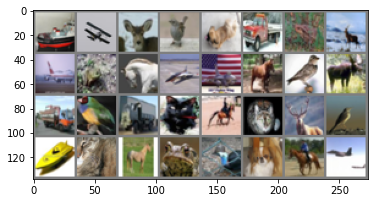

ship  plane deer  bird  dog   truck frog  deer  plane frog  horse plane plane horse bird  deer  truck bird  truck cat   horse cat   deer  bird  ship  cat   horse frog  bird  dog   horse plane


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [6]:
# Build a CNN model
class ConvolutionNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) 
        self.pool = nn.MaxPool2d(2, 2)  
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        ## Input image 3 x 32 x 32
        x = self.pool(F.relu(self.conv1(x))) # output 6 x 14 x 14
        x = self.pool(F.relu(self.conv2(x))) # output 16 x 5 x 5
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
# create an instance 
cnn_model = ConvolutionNet().to(device)
print(cnn_model)

ConvolutionNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [8]:
# Define the loss function and set the optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_model.parameters(), lr=0.001, momentum=0.9)

In [9]:
# Define the train and test function
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss = 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= num_batches
    print(f"Avg Train loss: {loss:>8f} \n")
    return train_loss

In [10]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

In [11]:
hist_training_loss = []
hist_test_loss = []
hist_test_acc = []
num_epochs = 20
for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss_now = train(trainloader, cnn_model, criterion, optimizer)
    test_loss_now, acc_test_now = test(testloader, cnn_model, criterion)
    hist_training_loss.append(train_loss_now)
    hist_test_loss.append(test_loss_now)
    hist_test_acc.append(acc_test_now)
print("Done!")

Epoch 1
-------------------------------
Avg Train loss: 2.131396 

Test Error: 
 Accuracy: 25.6%, Avg loss: 1.986037 

Epoch 2
-------------------------------
Avg Train loss: 1.928411 

Test Error: 
 Accuracy: 39.5%, Avg loss: 1.642791 

Epoch 3
-------------------------------
Avg Train loss: 2.203282 

Test Error: 
 Accuracy: 45.0%, Avg loss: 1.513298 

Epoch 4
-------------------------------
Avg Train loss: 1.773377 

Test Error: 
 Accuracy: 48.5%, Avg loss: 1.426565 

Epoch 5
-------------------------------
Avg Train loss: 1.561208 

Test Error: 
 Accuracy: 51.2%, Avg loss: 1.352322 

Epoch 6
-------------------------------
Avg Train loss: 1.345974 

Test Error: 
 Accuracy: 53.3%, Avg loss: 1.308758 

Epoch 7
-------------------------------
Avg Train loss: 0.890755 

Test Error: 
 Accuracy: 55.3%, Avg loss: 1.247949 

Epoch 8
-------------------------------
Avg Train loss: 1.107228 

Test Error: 
 Accuracy: 56.5%, Avg loss: 1.225036 

Epoch 9
-------------------------------
Avg Trai

In [12]:
import matplotlib.pyplot as plt

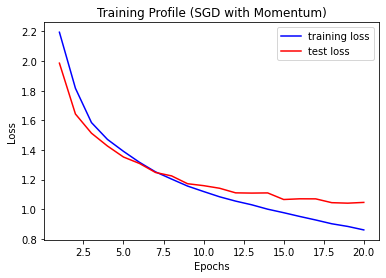

In [13]:
plt.plot(range(1,num_epochs+1), hist_training_loss, "-b", label = "training loss")
plt.plot(range(1,num_epochs+1), hist_test_loss, "-r", label = "test loss")
plt.legend(loc="best")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Profile (SGD with Momentum)")
plt.show()

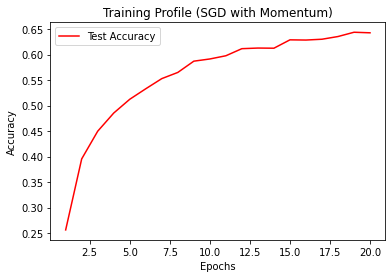

In [14]:
plt.plot(range(1,num_epochs+1), hist_test_acc, "-r", label = "Test Accuracy")
plt.legend(loc="best")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Profile (SGD with Momentum)")
plt.show()

In [15]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = cnn_model(images.to(device))
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 65.2 %
Accuracy for class: car   is 78.1 %
Accuracy for class: bird  is 50.8 %
Accuracy for class: cat   is 41.2 %
Accuracy for class: deer  is 54.3 %
Accuracy for class: dog   is 54.9 %
Accuracy for class: frog  is 67.7 %
Accuracy for class: horse is 78.2 %
Accuracy for class: ship  is 75.7 %
Accuracy for class: truck is 76.5 %
